Analyze trip files converted from OMX matrices
1. Are trips sorted by departure time?
2. How does the temporal distribution look?
3. What are the distribution by mode, purpose, VoT?

In [1]:
import numpy as np
import pandas as pd
import h5py
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Summarize OMX Trip Tables

In [2]:
matrix_folder = r'C:\Projects\SWIFT\SWIFT_Workspace\Scenarios\Scenario_S4_Full\STM\STM_D\Outputs_SWIFT'
matrices_am = ["OD AM3HR HBNW Vehicles", "OD AM3HR HBW Vehicles", "OD AM3HR NHB Vehicles", "OD AM3HR Other VEHICLEs"]
matrices_md = ["OD MD6HR HBNW Vehicles", "OD MD6HR HBW Vehicles", "OD MD6HR NHB Vehicles", "OD MD6HR Other VEHICLEs"]
matrices_pm = ["OD PM4HR HBNW Vehicles", "OD PM4HR HBW Vehicles", "OD PM4HR NHB Vehicles", "OD PM4HR Other VEHICLEs"]
matrices_ov = ["OD OV8HR HBNW Vehicles", "OD OV8HR HBW Vehicles", "OD OV8HR NHB Vehicles", "OD OV8HR Other VEHICLEs"]
matrices = matrices_am + matrices_md + matrices_pm + matrices_ov
matrix_files = [os.path.join(matrix_folder, m+'.omx') for m in matrices]
matrix_files

['C:\\Projects\\SWIFT\\SWIFT_Workspace\\Scenarios\\Scenario_S4_Full\\STM\\STM_D\\Outputs_SWIFT\\OD AM3HR HBNW Vehicles.omx',
 'C:\\Projects\\SWIFT\\SWIFT_Workspace\\Scenarios\\Scenario_S4_Full\\STM\\STM_D\\Outputs_SWIFT\\OD AM3HR HBW Vehicles.omx',
 'C:\\Projects\\SWIFT\\SWIFT_Workspace\\Scenarios\\Scenario_S4_Full\\STM\\STM_D\\Outputs_SWIFT\\OD AM3HR NHB Vehicles.omx',
 'C:\\Projects\\SWIFT\\SWIFT_Workspace\\Scenarios\\Scenario_S4_Full\\STM\\STM_D\\Outputs_SWIFT\\OD AM3HR Other VEHICLEs.omx',
 'C:\\Projects\\SWIFT\\SWIFT_Workspace\\Scenarios\\Scenario_S4_Full\\STM\\STM_D\\Outputs_SWIFT\\OD MD6HR HBNW Vehicles.omx',
 'C:\\Projects\\SWIFT\\SWIFT_Workspace\\Scenarios\\Scenario_S4_Full\\STM\\STM_D\\Outputs_SWIFT\\OD MD6HR HBW Vehicles.omx',
 'C:\\Projects\\SWIFT\\SWIFT_Workspace\\Scenarios\\Scenario_S4_Full\\STM\\STM_D\\Outputs_SWIFT\\OD MD6HR NHB Vehicles.omx',
 'C:\\Projects\\SWIFT\\SWIFT_Workspace\\Scenarios\\Scenario_S4_Full\\STM\\STM_D\\Outputs_SWIFT\\OD MD6HR Other VEHICLEs.omx',
 '

In [3]:
vots = {"hbwi1da": 9.6, "hbwi2da": 15.04, "hbwi3da": 20.48, "hbwi4da": 27.52, "hbwi5da": 37.12, "hbwi12a2": 21.56,
            "hbwai3a2": 35.84, "hbwi45a2": 56.56, "hbwi12a3": 30.8, "hbwi3a3": 51.2, "hbwi45a3": 80.8,
            "hnwi12da": 7.03, "hnwi3da": 13.44, "hnwi45da": 23.65, "hnwi12a2": 12.3, "hnwai3a2": 23.52,
            "hnwi45a2": 41.39,"hnwi12a3": 17.57, "hnwi3a3": 33.6, "hnwi45a3": 59.12,
            "nhodai12": 7.03, "nhodai3": 13.44, "nhodai453": 23.65, "nhos2i12": 12.3, "nhos2i3": 23.52,
            "nhos2i45": 41.39, "nhos3i12": 17.57, "nhos3i3": 33.6, "nhos3i45": 59.12,
            "nhwdai1": 9.6, "nhwdai2": 15.04, "nhwdai3": 20.48, "nhwdai4": 27.52, "nhwdai5": 37.12, "nhws2i12": 21.56,
            "nhws2i3": 35.84, "nhws2i45": 56.56, "nhws3i12": 30.8, "nhws3i3": 51.2, "nhws3i45": 80.8,
            "Cargo": 64.0, "Serv": 40.0, "taxi": 18.94, "exta": 18.94}

In [4]:
def parse_matrix_table(matrix_name, vots):
    """
    Parse the matrix name "amnhoai45" for vehicle type, value of time, period, and purpose
    :param matrix_name:
    :type str
    :param vots:        a dict for vots
    :return: a tuple, vehicle_type, occupancy, purpose, value_of_time, period
    """

    matrix_name = matrix_name.lower()

    vtype = occ = purp = vot = 0
    time_period = (0, 0)
    period = ''

    if matrix_name.find("all") >= 0:
        return dict(vtype=None, occ=None, purp=None, vot=None, time_period=None, period=None)

    if matrix_name.find("da") >= 0:
        vtype = 1
    elif matrix_name.find("s2") >= 0 or matrix_name.find("a2") >= 0:
        vtype = 2
    elif matrix_name.find("s3") >= 0 or matrix_name.find("a3") >= 0:
        vtype = 3
    elif matrix_name.find("cargo") >= 0:
        vtype = 6
    elif matrix_name.find("serv") >= 0:
        vtype = 5
    elif matrix_name.find("taxi") >= 0:
        vtype = 4
    elif matrix_name.find("exta") >= 0:
        vtype = 1

    if vtype == 1:
        occ = 0
    elif vtype == 2 or vtype == 3 or vtype == 4:
        occ = 2
    elif vtype == 5 or vtype == 6:
        occ = 1

    if matrix_name.find("hbw") >= 0:
        purp = 1
    elif matrix_name.find("hnw") >= 0:
        purp = 2
    elif matrix_name.find("nhw") >= 0:
        purp = 3
    elif matrix_name.find("nho") >= 0:
        purp = 4
    else:
        purp = 5

    if matrix_name.find("am") >= 0:
        period = 'am'
    elif matrix_name.find("md") >= 0:
        period = 'md'
    elif matrix_name.find("pm") >= 0:
        period = 'pm'
    else:
        period = 'ov'

    for key in vots.keys():
        if matrix_name.find(key) >= 0:
            vot = vots[key]
            break

    return dict(vtype=vtype, occ=occ, purp=purp, vot=vot, time_period=time_period, period=period)

In [5]:
def summarize_trip_tables(matrix_files, vots):
    summary_records = []
    for m in matrix_files:
        print('Processing Matrix File {:s}'.format(m))
        h5 = h5py.File(m, 'r')
        tables = h5['/data/'].keys()
        for table in tables:
            if table.find('all') >= 0:
                continue
            print('Processing Matrix {:s}'.format(table))
            info = parse_matrix_table(table, vots)
            vtype = info['vtype']
            occ = info['occ']
            purp = info['purp']
            vot = info['vot']
            period = info['period']
            od = h5['/data/' + table][:]
            trips = od.sum()
            summary_records.append((table.lower(), period, purp, vot, vtype, occ, trips))
    
    return pd.DataFrame(data=summary_records, columns=['table', 'period', 'purp', 'vot', 'vtype', 'occ', 'trips'])
    

In [6]:
summary_omx = summarize_trip_tables(matrix_files, vots)

Processing Matrix File C:\Projects\SWIFT\SWIFT_Workspace\Scenarios\Scenario_S4_Full\STM\STM_D\Outputs_SWIFT\OD AM3HR HBNW Vehicles.omx
Processing Matrix amhnwi3da
Processing Matrix amhnwi12da
Processing Matrix amhnwai3a2
Processing Matrix amhnwi45da
Processing Matrix amhnwi45a3
Processing Matrix amhnwi3a3
Processing Matrix amhnwi12a3
Processing Matrix amhnwi12a2
Processing Matrix amhnwi45a2
Processing Matrix File C:\Projects\SWIFT\SWIFT_Workspace\Scenarios\Scenario_S4_Full\STM\STM_D\Outputs_SWIFT\OD AM3HR HBW Vehicles.omx
Processing Matrix amhbwi12a2
Processing Matrix amhbwi45a2
Processing Matrix amhbwi2da
Processing Matrix amhbwi45a3
Processing Matrix amhbwi3da
Processing Matrix amhbwi3a3
Processing Matrix amhbwi1da
Processing Matrix amhbwi4da
Processing Matrix amhbwai3a2
Processing Matrix amhbwi12a3
Processing Matrix amhbwi5da
Processing Matrix File C:\Projects\SWIFT\SWIFT_Workspace\Scenarios\Scenario_S4_Full\STM\STM_D\Outputs_SWIFT\OD AM3HR NHB Vehicles.omx
Processing Matrix amnhws2

In [7]:
summary_omx

,table,period,purp,vot,vtype,occ,trips
0,amhnwi3da,am,2,13.44,1,0,217573.6069
1,amhnwi12da,am,2,7.03,1,0,224344.2256
2,amhnwai3a2,am,2,23.52,2,2,60194.4136
3,amhnwi45da,am,2,23.65,1,0,617642.9429
4,amhnwi45a3,am,2,59.12,3,2,38497.8920
5,amhnwi3a3,am,2,33.60,3,2,17305.6450
6,amhnwi12a3,am,2,17.57,3,2,20473.0489
7,amhnwi12a2,am,2,12.30,2,2,65637.7263
8,amhnwi45a2,am,2,41.39,2,2,157094.1000
9,amhbwi12a2,am,1,21.56,2,2,11456.8700


#### Input Trips Period Subtotals

In [8]:
df_input_period_totals = summary_omx.groupby('period', as_index=False)['trips'].sum()
df_input_period_totals['share'] = df_input_period_totals.trips / sum(df_input_period_totals.trips)
df_input_period_totals

,period,trips,share
0,am,3.876891e+06,0.138051
1,md,9.993898e+06,0.355870
2,ov,5.001853e+06,0.178110
3,pm,9.210338e+06,0.327969


### Summary Converted Trip File

In [9]:
flat_trip_file = r'C:\Projects\SWIFT\SWIFT_Workspace\Scenarios\Scenario_S4_Full\STM\STM_A\01_DynusT\02_Demand\vehicle.csv'

In [10]:
df_flat_trip = pd.read_csv(flat_trip_file)
df_flat_trip.head()

,vid,usec,dsec,stime,vehcls,vehtype,ioc,#ONode,#IntDe,info,...,Izone,Evac,InitPos,VoT,tFlag,pArrTime,TP,IniGas,DZone,waitTime
0,1,240342,12236,0.0,3,1,0,1,1,0,...,51,0,0.9480,20.48,0,0.0,1,0.0,2937,0.0
1,2,241878,79290,0.0,3,1,0,1,1,0,...,57,0,0.0594,20.48,0,0.0,1,0.0,3830,0.0
2,3,286147,21423,0.0,3,1,0,1,1,0,...,268,0,0.2690,20.48,0,0.0,1,0.0,1798,0.0
3,4,10583,45372,0.0,3,1,0,1,1,0,...,418,0,0.1862,20.48,0,0.0,1,0.0,418,0.0
4,5,92752,165716,0.0,3,1,0,1,1,0,...,464,0,0.3105,20.48,0,0.0,1,0.0,465,0.0


#### Are trips sorted by departure time in non-decreasing order?

In [12]:
print('Trips are sorted by stime in increasing order = {:s}'.format(str(df_flat_trip.stime.is_monotonic_increasing)))

Trips are sorted by stime in increasing order = True


#### Compare temporal distribution

In [23]:
INPUT_DIURNAL_FILE = r'C:\Projects\SWIFT\SWIFT_Workspace\CommonData\STM\STM_A\Shared_Inputs\Diurnal_Full.csv'

In [24]:
df_input_diurnal = pd.read_csv(INPUT_DIURNAL_FILE)
df_input_diurnal

,HOUR,SHARE
0,0.0,0.000100
1,0.1,0.000104
2,0.2,0.000106
3,0.3,0.000107
4,0.4,0.000108
5,0.5,0.000108
6,0.6,0.000107
7,0.7,0.000106
8,0.8,0.000104
9,0.9,0.000102


#### Input Diurnal Period Totals

In [25]:
def period(r):
    if 0 <= r < 6 or 19 <= r < 24:
        return 'ov'
    elif 6 <= r < 9:
        return 'am'
    elif 9 <= r < 15:
        return 'md'
    else:
        return 'pm'

In [26]:
df_input_diurnal['period'] = df_input_diurnal.HOUR.apply(period)
df_input_diurnal_period_totals = df_input_diurnal.groupby('period', as_index=False)['SHARE'].sum()
df_input_diurnal_period_totals

,period,SHARE
0,am,0.211483
1,md,0.340290
2,ov,0.135476
3,pm,0.312750


In [27]:
df_converted_diurnal = pd.DataFrame(pd.cut(x=df_flat_trip.stime, bins=df_input_diurnal.HOUR, right=False).value_counts()).sort_index().reset_index()
df_converted_diurnal

,index,stime
0,"[0.0, 0.1)",4152
1,"[0.1, 0.2)",3770
2,"[0.2, 0.3)",4411
3,"[0.3, 0.4)",4280
4,"[0.4, 0.5)",4491
5,"[0.5, 0.6)",5067
6,"[0.6, 0.7)",4302
7,"[0.7, 0.8)",4084
8,"[0.8, 0.9)",4218
9,"[0.9, 1.0)",4171


In [28]:
df_diurnals_wide = pd.DataFrame({'hour': df_input_diurnal.HOUR.values[1:], 
                           'input': df_input_diurnal.SHARE.values[1:],
                           'converted': df_converted_diurnal.stime / np.sum(df_converted_diurnal.stime)
                           })
df_diurnals = df_diurnals_wide.melt(id_vars='hour', value_vars=['input','converted'])
df_diurnals.head()

,hour,variable,value
0,0.1,input,0.000104
1,0.2,input,0.000106
2,0.3,input,0.000107
3,0.4,input,0.000108
4,0.5,input,0.000108


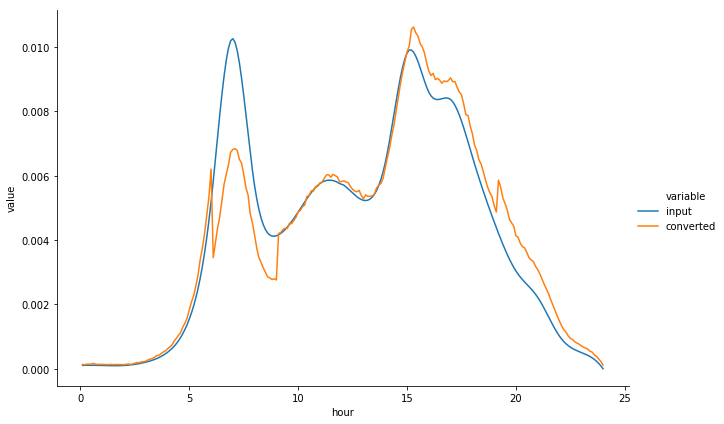

In [29]:
# fig, ax = plt.subplots(figsize=(12,8))
g = sns.relplot(x="hour", y="value", hue='variable', kind="line", data=df_diurnals, aspect=1.5, height=6)